<a href="https://colab.research.google.com/github/kate-melnykova/bird_recognition/blob/master/backend/ml/Initial_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bird classification problem
You have seen a beautiful bird in the North America, and maybe you have no idea about its name but would like to know? This project aims to classify the birds by their photos.

## Data
Data is a courtesy of Kaggle datasets

https://www.kaggle.com/gpiosenka/100-bird-species

**Description from the website**
Images were gather from internet searches by species name. Once the image files for a species was downloaded they were checked for duplicate images using a python duplicate image detector program I developed. All duplicates detected were deleted in order to prevent their being images common between the training, test and validation sets.
After that the images were cropped so that the bird occupies at least 50% of the pixel in the image. Then the images were resized to 224 X 224 X3 in jpg format.

# Import packages

In [1]:
# import packages
import os, io
from shutil import rmtree

import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# load tensorflow packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, BatchNormalization,Activation, Lambda, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import resize
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Set up directories

In [4]:
import os
folder = '/content/drive/My Drive/Bird_classification/'
train_dir = os.path.join(folder, '/train')
print(train_dir)
os.path.join('content', 'drive','My Drive','Bird_classification', 
             'train')

/train


'content/drive/My Drive/Bird_classification/train'

In [ ]:
train_dir

'/content/drive/My Drive/Bird_classification/train'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset preprocessing (should be done once)

Many labels have a very few images. I want to drop all classes that have less than 10 images in the training set.

In [ ]:
to_keep = list()
for f in os.listdir(train_dir):
    if len(list(os.listdir(train_dir + '/' + f))) > 10:
        to_keep.append(folder)

print(f'We keep {len(to_keep)} many species')
print(f'Here is their list')
for name in sorted(to_keep):
    print(name)

We keep 235 many species
Here is their list
AFRICAN CROWNED CRANE
AFRICAN FIREFINCH
ALBATROSS
ALEXANDRINE PARAKEET
AMERICAN AVOCET
AMERICAN BITTERN
AMERICAN COOT
AMERICAN GOLDFINCH
AMERICAN KESTREL
AMERICAN PIPIT
AMERICAN REDSTART
ANHINGA
ANNAS HUMMINGBIRD
ANTBIRD
ARARIPE MANAKIN
ASIAN CRESTED IBIS
BALD EAGLE
BALI STARLING
BALTIMORE ORIOLE
BANANAQUIT
BAR-TAILED GODWIT
BARN OWL
BARN SWALLOW
BARRED PUFFBIRD
BAY-BREASTED WARBLER
BEARDED BARBET
BELTED KINGFISHER
BIRD OF PARADISE
BLACK FRANCOLIN
BLACK SKIMMER
BLACK SWAN
BLACK THROATED WARBLER
BLACK VULTURE
BLACK-CAPPED CHICKADEE
BLACK-NECKED GREBE
BLACK-THROATED SPARROW
BLACKBURNIAM WARBLER
BLUE GROUSE
BLUE HERON
BOBOLINK
BROWN NOODY
BROWN THRASHER
CACTUS WREN
CALIFORNIA CONDOR
CALIFORNIA GULL
CALIFORNIA QUAIL
CANARY
CAPE MAY WARBLER
CAPUCHINBIRD
CARMINE BEE-EATER
CASPIAN TERN
CASSOWARY
CHARA DE COLLAR
CHIPPING SPARROW
CHUKAR PARTRIDGE
CINNAMON TEAL
COCK OF THE  ROCK
COCKATOO
COMMON GRACKLE
COMMON HOUSE MARTIN
COMMON LOON
COMMON POORWILL
CO

In [ ]:
# Run with caution - deletes the data
for folder in os.listdir(train_dir):
    if folder not in to_keep:
        rmtree(train_dir + '/' + folder)

for folder in os.listdir(valid_dir):
    if folder not in to_keep:
        rmtree(valid_dir + '/' + folder)

# Image Data Generator


In [ ]:
batch_size = 256

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                 rotation_range=30,
                                 width_shift_range=10,
                                 height_shift_range=10,
                                 zoom_range=0.2,
                                 shear_range=0.2,
                                 horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=1/255,
                                 rotation_range=30,
                                 width_shift_range=10,
                                 height_shift_range=10,
                                 zoom_range=0.2,
                                 shear_range=0.2,
                                 horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255)

In [ ]:
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               seed=42,
                                               batch_size=batch_size,
                                               shuffle=True, 
                                               class_mode="sparse",
                                               target_size=(224,224))

valid_data = valid_datagen.flow_from_directory(directory=valid_dir,
                                               seed=42,
                                               batch_size=batch_size,
                                               shuffle=True, 
                                               class_mode="sparse",
                                               target_size=(224,224))

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               seed=42,
                                               batch_size=batch_size,
                                               shuffle=True, 
                                               class_mode="sparse",
                                               target_size=(224,224))

Found 32672 images belonging to 235 classes.
Found 1175 images belonging to 235 classes.
Found 1175 images belonging to 235 classes.


In [ ]:
train_data.class_indices

{'AFRICAN CROWNED CRANE': 0,
 'AFRICAN FIREFINCH': 1,
 'ALBATROSS': 2,
 'ALEXANDRINE PARAKEET': 3,
 'AMERICAN AVOCET': 4,
 'AMERICAN BITTERN': 5,
 'AMERICAN COOT': 6,
 'AMERICAN GOLDFINCH': 7,
 'AMERICAN KESTREL': 8,
 'AMERICAN PIPIT': 9,
 'AMERICAN REDSTART': 10,
 'ANHINGA': 11,
 'ANNAS HUMMINGBIRD': 12,
 'ANTBIRD': 13,
 'ARARIPE MANAKIN': 14,
 'ASIAN CRESTED IBIS': 15,
 'BALD EAGLE': 16,
 'BALI STARLING': 17,
 'BALTIMORE ORIOLE': 18,
 'BANANAQUIT': 19,
 'BAR-TAILED GODWIT': 20,
 'BARN OWL': 21,
 'BARN SWALLOW': 22,
 'BARRED PUFFBIRD': 23,
 'BAY-BREASTED WARBLER': 24,
 'BEARDED BARBET': 25,
 'BELTED KINGFISHER': 26,
 'BIRD OF PARADISE': 27,
 'BLACK FRANCOLIN': 28,
 'BLACK SKIMMER': 29,
 'BLACK SWAN': 30,
 'BLACK THROATED WARBLER': 31,
 'BLACK VULTURE': 32,
 'BLACK-CAPPED CHICKADEE': 33,
 'BLACK-NECKED GREBE': 34,
 'BLACK-THROATED SPARROW': 35,
 'BLACKBURNIAM WARBLER': 36,
 'BLUE GROUSE': 37,
 'BLUE HERON': 38,
 'BOBOLINK': 39,
 'BROWN NOODY': 40,
 'BROWN THRASHER': 41,
 'CACTUS WREN':

In [ ]:
n_classes = len(train_data.class_indices)
print(f'Found {n_classes} classes of birds')

Found 235 classes of birds


# Build a model
## Transfer learning form ResNet101V2

In [ ]:
baseline = ResNet101V2(input_shape=(224,224,3),
                       include_top=False)
for layer in baseline.layers:
    layer.trainable=False

## Model build and compile

In [ ]:
# model is taken from https://www.kaggle.com/anuragmishra2311/birds-classification-using-resnet-101
model = Sequential()
model.add(Input(shape=(224,224,3)))
model.add(baseline)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5)),
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))
model.layers[0].trainable = False

In [ ]:
model.compile(loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()],
              optimizer=Adam(lr=0.001))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 7, 7, 2048)        42626560  
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 100352)            401408    
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              205522944 
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
activation_2 (Activation)    (None, 2048)             

## Model fitting - step 1

The suggested number of epochs is 5, and each of them runs about 3 hours on GPU. Therefore, the expected running time exceeds 12 hours. I split on 2 + 3 epochs.

In [ ]:
folder = '/content/drive/My Drive/Bird_classification'

In [ ]:
weight_path = folder + '/' + 'initial_model_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_sparse_categorical_accuracy', 
                              mode = 'max' , 
                              patience = 10,
                              verbose = 1,
                              restore_best_weights=True)

checkpoint = ModelCheckpoint(weight_path, 
                                monitor = 'val_sparse_categorical_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [ ]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=500,
                    callbacks=callback_list)

Epoch 1/500
128/128 [==============================] - 438s 3s/step - loss: 0.5208 - sparse_categorical_accuracy: 0.8522 - val_loss: 0.2142 - val_sparse_categorical_accuracy: 0.9345

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.93447, saving model to /content/drive/My Drive/Bird_classificationinitial_model_weights.hdf5
Epoch 2/500
128/128 [==============================] - 509s 4s/step - loss: 0.4743 - sparse_categorical_accuracy: 0.8627 - val_loss: 0.2017 - val_sparse_categorical_accuracy: 0.9353

Epoch 00002: val_sparse_categorical_accuracy improved from 0.93447 to 0.93532, saving model to /content/drive/My Drive/Bird_classificationinitial_model_weights.hdf5
Epoch 3/500
128/128 [==============================] - 520s 4s/step - loss: 0.4332 - sparse_categorical_accuracy: 0.8726 - val_loss: 0.1775 - val_sparse_categorical_accuracy: 0.9464

Epoch 00003: val_sparse_categorical_accuracy improved from 0.93532 to 0.94638, saving model to /content/drive/My Drive/Bird_

# Model analysis

In [ ]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

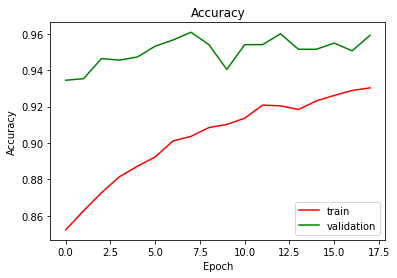

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'], c='red', marker='+')
plt.plot(history.history['val_sparse_categorical_accuracy'], c='green', marker='*')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation'], loc='lower right')
plt.show()

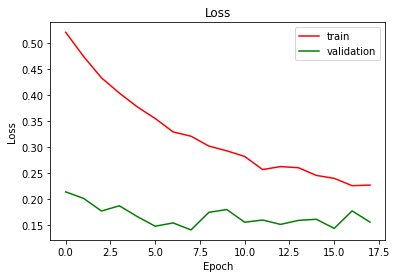

In [ ]:
plt.plot(history.history['loss'], c='red', marker='+')
plt.plot(history.history['val_loss'],c='green', marker='*')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','validation'],loc='upper right')
plt.show()

In [ ]:
model.evaluate(test_data)

5/5 [==============================] - 379s 94s/step - loss: 0.0633 - sparse_categorical_accuracy: 0.9787


[0.06326599419116974, 0.978723406791687]

In [ ]:
model.save('/content/drive/My Drive/Bird_classification/initial_resnet101v2_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Bird_classification/initial_resnet101v2_model/assets


In [ ]:
dic = train_data.class_indices
label_converter = pd.DataFrame(dic.items())
label_converter.head()
label_converter.to_csv('/content/drive/My Drive/Bird_classification/label_converter_initial_model.csv')

# Prediction

In [ ]:
import random

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# Way 1: load from the test folder
all_test_labels = list()
for o in os.listdir(test_dir):
    new_path = os.path.join(test_dir, o)
    if os.path.isdir(new_path):
        all_test_labels.append(new_path)

folder_id = all_test_labels[random.randint(0, len(all_test_labels) - 1)]
n_images = len(os.listdir(folder_id))
image_id = os.path.join(folder_id, list(os.listdir(image_id))[random.randint(0, n_images-1)])
img = load_img(image_id)
print(f'Bird image is {image_id}')

In [ ]:
# Way 2: Load external image

In [ ]:
dic = train_data.class_indices
recover_labels = {k:v for v,k in dic.items()}
def output():
    img = load_img(location,target_size=(224,224,3))
    img = img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict_classes(img)
    confident = 0
    for prob, answer in zip(model.predict_proba(img), answer):
        if prob > 0.8:
            print(f'{prob * 100} % chances are there that the bird is {recover_labels[answer[0]]}')
            confident += 1
    if not confident:
        print(f'No match found')